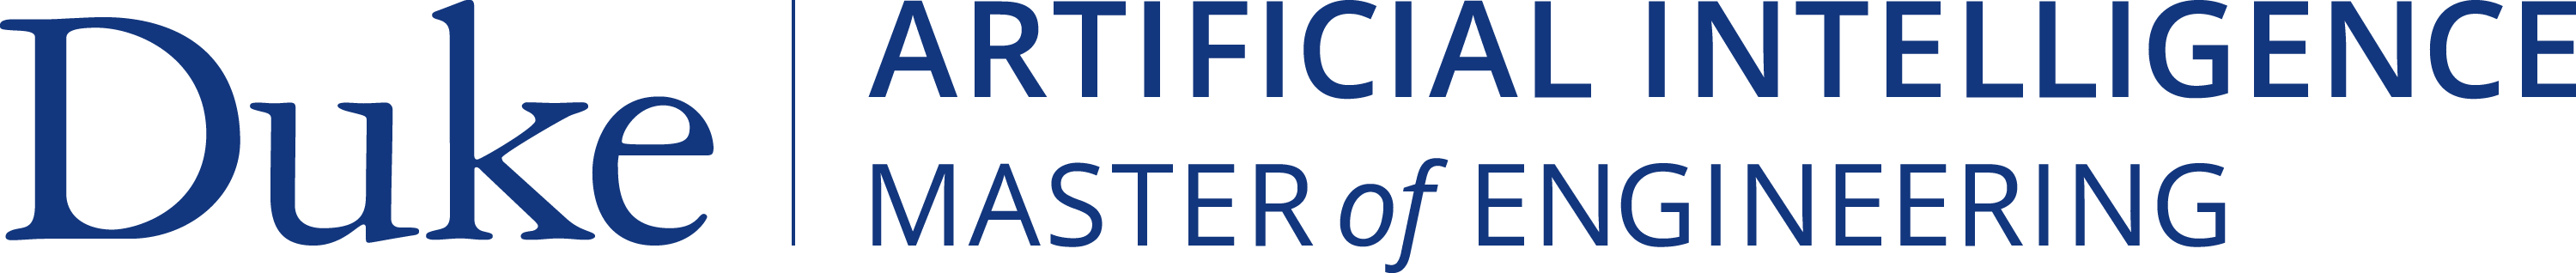


# AIPI 590 Applied Computer Vision
## Project 1 - Scene Recognition
- Keese Phillips

# Attribution:
[Modern-Computer-Vision-with-PyTorch](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch)


In [ ]:
!pip install torchmetrics
!pip install torch_summary
!pip install onnx

In [ ]:
import os
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
from torchsummary import summary
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import imgaug.augmenters as iaa
import imgaug as ia
import requests
import tarfile
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# This occured as some issue I found with my specific version of numpy uncomment if you run into any errors
# np.bool = np.bool_

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using CUDA device


In [ ]:
def download_file(url, filename):
  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as f:
      for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

    print(f"File downloaded successfully to: {filename}")

  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")


url = "http://vision.princeton.edu/projects/2010/SUN/SUN397.tar.gz"
filename = "SUN397.tar.gz"

download_file(url, filename)


File downloaded successfully to: SUN397.tar.gz


In [ ]:
def extract_tar_gz(filename, destination):
  try:
    with tarfile.open(filename, "r:gz") as tar:
      tar.extractall(path=destination)
    print(f"File extracted successfully to: {destination}")
  except Exception as e:
    print(f"Error extracting file: {e}")


filename = "SUN397.tar.gz"
destination = os.getcwd()
extract_tar_gz(filename, destination)


In [ ]:
source_folder = os.getcwd() + "/SUN397"
train_folder = os.getcwd() + "/training_set"
test_folder = os.getcwd() + "/test_set"

with open('SUN397/ClassName.txt', 'r') as f:
  class_names = f.read()

class_names = class_names.split('\n')
class_names = list(filter(None, class_names))

In [ ]:
def create_train_test_sets(class_names, source_folder, train_folder, test_folder, test_size=0.2):
  if not os.path.exists(train_folder):
    os.makedirs(train_folder)
  if not os.path.exists(test_folder):
    os.makedirs(test_folder)

  for class_name in class_names:
    class_path = source_folder + class_name
    if os.path.isdir(class_path):
      print(f"\rProcessing class: {class_name}", end='')
      image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
      if len(image_files) > 0:
        train_files, test_files = train_test_split(image_files, test_size=test_size)

        train_class_folder = train_folder + class_name
        test_class_folder = test_folder + class_name

        if not os.path.exists(train_class_folder):
          os.makedirs(train_class_folder)
        if not os.path.exists(test_class_folder):
          os.makedirs(test_class_folder)

        for file in train_files:
          source_file_path = os.path.join(class_path, file)
          destination_file_path = os.path.join(train_class_folder, file)
          shutil.copy(source_file_path, destination_file_path)

        for file in test_files:
          source_file_path = os.path.join(class_path, file)
          destination_file_path = os.path.join(test_class_folder, file)
          shutil.copy(source_file_path, destination_file_path)

create_train_test_sets(class_names, source_folder, train_folder, test_folder)


Processing class: /y/youth_hostel

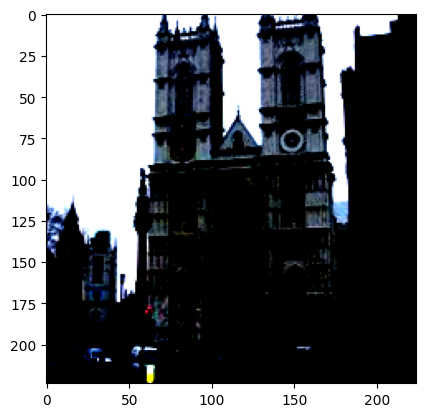

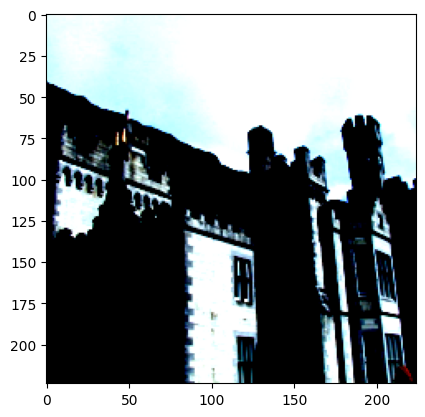

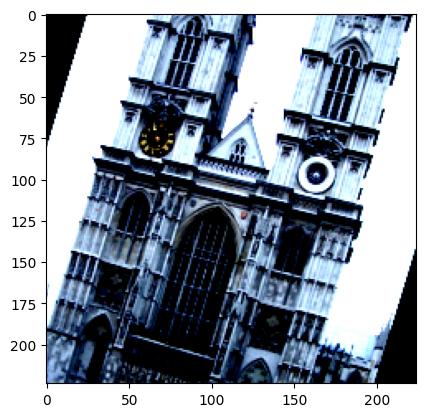

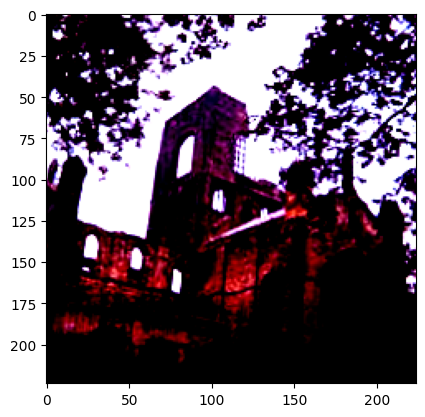

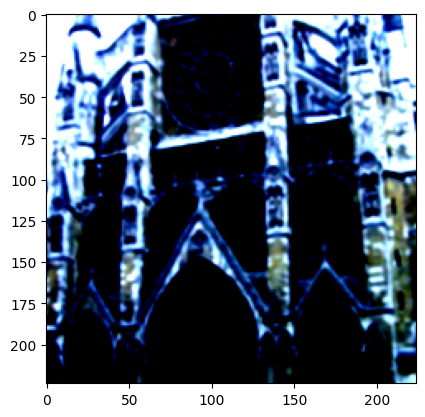

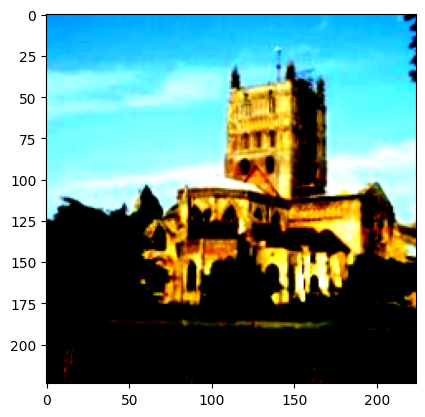

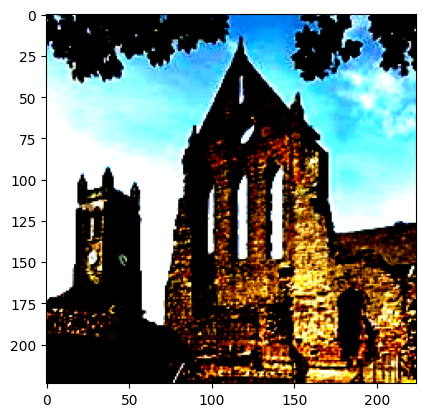

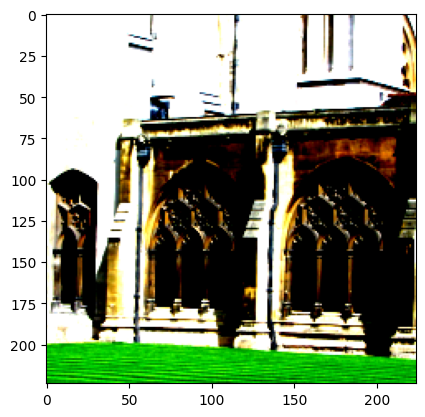

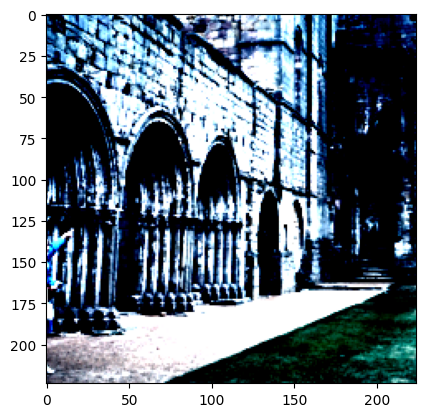

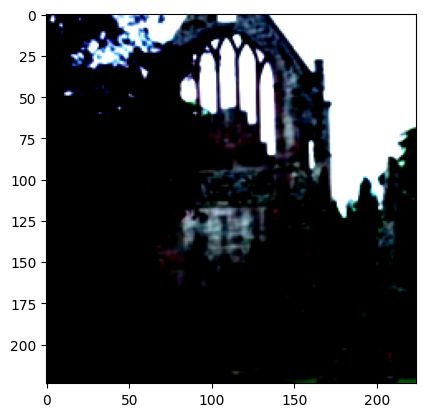

In [ ]:
seq = iaa.Sequential([
    iaa.SomeOf((0, 2), [ # Apply 0 to 2 of the following augmentations
        iaa.Fliplr(0.5), # Horizontal flips with probability 0.5
        iaa.Crop(percent=(0, 0.1)), # Random crops up to 10% of the image
        iaa.Affine(rotate=(-20, 20)), # Rotations between -20 and 20 degrees
        iaa.GaussianBlur(sigma=(0, 3.0)) # Gaussian blur with sigma between 0 and 3.0
    ])
], random_order=True)


class SunDatabase(Dataset):
    def __init__(self, folder, class_list, label_encoder, seq=seq, transform=None):
        self.fpaths = []
        self.targets = []
        for class_name in class_list:
            fpaths_class = glob(folder + '/' + class_name + '/*.jpg')
            self.fpaths.extend(fpaths_class)
            self.targets.extend([class_name] * len(fpaths_class))

        self.targets = label_encoder.transform(self.targets)

        self.transform = transforms.Compose([
            transforms.Resize(232),  # Resize to 256
            transforms.CenterCrop(224),  # Center crop to 224
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # Normalize
        ])

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = Image.open(f).convert('RGB')
        im_np = np.array(im)
        im_aug = seq(image=im_np)
        im = Image.fromarray(im_aug)
        im = self.transform(im)

        return im.float().to(device), target

dataloader = {}
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
dataset = SunDatabase(train_folder,class_names,label_encoder, seq)

for index in range(200, 210):
  image_tensor, target = dataset[index]

  image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

  plt.imshow(image_np)
  plt.show()

In [ ]:
def get_model():
    model = models.resnet152(weights='IMAGENET1K_V2', progress=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, len(class_names)))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))
torch.onnx.export(model, torch.zeros(1,3,224,224).to(device), "model.onnx")

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 153MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data(label_encoder):
    train = SunDatabase(train_folder,class_names,label_encoder)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = SunDatabase(test_folder,class_names,label_encoder)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
dataloader = {}
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
dataloader['train'], dataloader['val'] = get_data(label_encoder)
model, loss_fn, optimizer = get_model()

In [15]:
def train_model(model, loss_fn, optimizer, dataloader, num_epochs=5):
  train_losses, train_accuracies = [], []
  val_accuracies = []
  for epoch in range(num_epochs):
      print(f" epoch {epoch}/5")
      train_epoch_losses, train_epoch_accuracies = [], []
      val_epoch_accuracies = []

      for ix, batch in enumerate(iter(dataloader['train'])):
          x, y = batch
          batch_loss = train_batch(x.to(device), y.to(device), model, optimizer, loss_fn)
          train_epoch_losses.append(batch_loss)
      train_epoch_loss = np.array(train_epoch_losses).mean()

      for ix, batch in enumerate(iter(dataloader['train'])):
          x, y = batch
          is_correct = accuracy(x.to(device), y.to(device), model)
          train_epoch_accuracies.extend(is_correct)
      train_epoch_accuracy = np.mean(train_epoch_accuracies)

      for ix, batch in enumerate(iter(dataloader['val'])):
          x, y = batch
          val_is_correct = accuracy(x.to(device), y.to(device), model)
          val_epoch_accuracies.extend(val_is_correct)
      val_epoch_accuracy = np.mean(val_epoch_accuracies)

      train_losses.append(train_epoch_loss)
      train_accuracies.append(train_epoch_accuracy)
      val_accuracies.append(val_epoch_accuracy)

      return model, train_losses, train_accuracies, val_accuracies

model, train_losses, train_accuracies, val_accuracies = train_model(model, loss_fn, optimizer, dataloader, num_epochs=5)
torch.save(model.state_dict(), './resnet152_sun.pt')

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


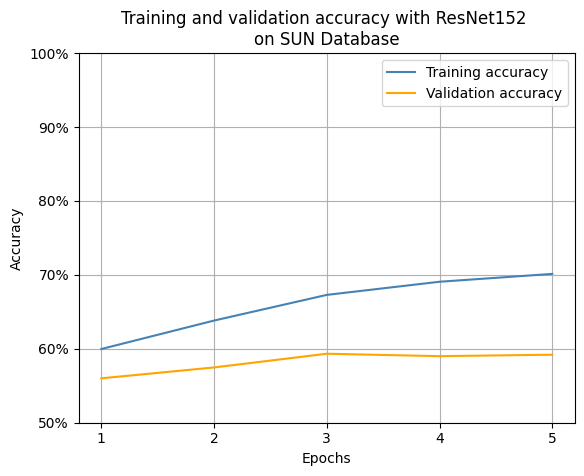

In [48]:
def visualize_training(train_losses, train_accuracies, val_accuracies, num_epochs=5):
  epochs = np.arange(5)+1
  plt.plot(epochs, train_accuracies, 'steelblue', label='Training accuracy')
  plt.plot(epochs, val_accuracies, 'orange', label='Validation accuracy')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Training and validation accuracy with ResNet152 \non SUN Database')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0.5,1)
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
  plt.legend()
  plt.grid('off')
  plt.show()

visualize_training(train_losses, train_accuracies, val_accuracies, num_epochs=5)

In [52]:
def evaluate_model(model, dataloader):
  top1_accuracy = Accuracy(task='multiclass',num_classes=len(class_names),top_k=1)
  top5_accuracy = Accuracy(task='multiclass',num_classes=len(class_names),top_k=5)

  all_preds = []
  all_labels = []

  model.eval()

  with torch.no_grad():
      for inputs, targets in dataloader['val']:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs).to(device)

          top1_accuracy(outputs.cpu(), targets.cpu())
          top5_accuracy(outputs.cpu(), targets.cpu())

          _, preds = torch.max(outputs.cpu(), 1)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(targets.cpu().numpy())

  final_top1 = top1_accuracy.compute()
  final_top5 = top5_accuracy.compute()

  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)

  cm = confusion_matrix(label_encoder.inverse_transform(all_labels), label_encoder.inverse_transform(all_preds))
  class_accuracy = cm.diagonal() / cm.sum(axis=1)
  class_performance = dict(zip(class_names, class_accuracy))

  sorted_classes = pd.DataFrame(sorted(class_performance.items(), key=lambda x: x[1]))
  sorted_classes.columns = ['Class', 'Accuracy']
  sorted_classes['Class'] = sorted_classes['Class'].apply(lambda x: x.split("/", 2)[2])

  return final_top1, final_top5, sorted_classes

final_top1, final_top5, sorted_classes = evaluate_model(model, dataloader)

In [79]:
print("Lowest Accuracy Classes")
sorted_classes.head(5)

Lowest Accuracy Classes


,Class,Accuracy
0,biology_laboratory,0.0
1,bistro/indoor,0.0
2,hunting_lodge/outdoor,0.0
3,inn/outdoor,0.0
4,synagogue/indoor,0.0


In [81]:
print("Highest Accuracy Classes")
sorted_classes.tail(5)

Highest Accuracy Classes


,Class,Accuracy
392,wine_cellar/barrel_storage,0.920000
393,oilrig,0.928571
394,ball_pit,0.951220
395,florist_shop/indoor,0.967742
396,underwater/coral_reef,0.969697


In [43]:
print(f'Top-1 Accuracy: {final_top1:.4f}')
print(f'Top-5 Accuracy: {final_top5:.4f}')

Top-1 Accuracy: 0.5918
Top-5 Accuracy: 0.8584
